In [1]:
import pandas as pd
df_finphrasebank = pd.read_csv("df_phrasebank.csv", index_col = 0)

# Convert to Glove numeric vector (6B-300d) and perform padding

In [2]:
def read_glove_vecs(glove_file):
    '''
    This function is to create 3 Dictionaries that can interact with the glove pre-trained weightings
    Input:
        glove_file: the directory of the pre-trained file
    Output:
        words_to_index: A directory that can use words as name and return back the index
        index_to_words: A directory that can use index as name and return back the words
        word_to_vec_map: A directory that can use words as name and directly return the Vector mapping
    '''
    with open(glove_file, 'r', encoding="utf-8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def sentences_to_indices(X, word_to_index, Tx):
    """
    This function is to converts an array of sentences into an array of indices corresponding to words in the sentences.
    The output shape should match with the embedding dimension.
    
    Input:
        X: array of sentences (strings), of shape (m, 1), i.e. m samples.
        word_to_index: a dictionary called for converting word into index
        Tx: maximum number of words in a sentence. Sentences exceeds this number will be cut 
    
    Returns:
    X_indices: array of indices corresponding to words in the sentences from X, of shape (m, Tx)
    """
    
    m = X.shape[0] # number of data in the dataset
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape 
    X_indices = np.zeros((m, Tx))
    
    for i in range(m):
        sentence_words = X[i].split() #split sentence into a list of word
        sentence_words = sentence_words[0:Tx] # Cut all Words Once it search the maximun lenght Tx
        
        j = 0 # initialize the counter of word in every sentence
        
        for w in sentence_words: # convert word into index and input in the (i,j) elements of X_indices
            try: # try to see if the word is in the glove corpus
                X_indices[i, j] = word_to_index[w]
                j = j+1
            except: #if not, skip it and left that (i,j) elements as 0
                j = j+1
    
    return X_indices

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.astype(int)]
    return Y


In [3]:
import numpy as np
glove_file = "./Raw data/glove.6B.300d.txt"

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(glove_file)

from sklearn.model_selection import train_test_split
X_train_phrasebank, X_test_phrasebank, y_train_phrasebank, y_test_phrasebank = train_test_split(df_finphrasebank.text, 
                                                                                                df_finphrasebank.label, 
                                                                                                test_size = 0.2, 
                                                                                                random_state=6543)

X_train_phrasebank_text = X_train_phrasebank.to_numpy()
X_train_phrasebank_indixes = sentences_to_indices(X_train_phrasebank_text, word_to_index, Tx = 50)  

X_test_phrasebank_text = X_test_phrasebank.to_numpy()
X_test_phrasebank_indixes = sentences_to_indices(X_test_phrasebank_text, word_to_index, Tx = 50)  

y_train_phrasebank = y_train_phrasebank.to_numpy()
y_test_phrasebank = y_test_phrasebank.to_numpy()

Y_oh_train_phrasebank = convert_to_one_hot(y_train_phrasebank, C = 3)
Y_oh_test_phrasebank = convert_to_one_hot(y_test_phrasebank, C = 3)

a = (df_finphrasebank.label == -1).mean()
b = (df_finphrasebank.label == 0).mean()
c = (df_finphrasebank.label == 1).mean()
y_train_phrasebank_weight = np.zeros((y_train_phrasebank.shape))
y_train_phrasebank_weight[y_train_phrasebank == -1] = (1/3)/a
y_train_phrasebank_weight[y_train_phrasebank == 0] = (1/3)/b
y_train_phrasebank_weight[y_train_phrasebank == 1] = (1/3)/c

In [5]:
import keras 
from keras.layers.embeddings import Embedding
from keras import callbacks
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, Input, SimpleRNN, Bidirectional, Dropout, BatchNormalization, LSTM
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    vocab_len = len(word_to_index) + 1    # adding 1 to fit Keras embedding, special requirement for using Keras
    emb_dim = word_to_vec_map["apple"].shape[0]      # get dimensionality pre-trained embedding
    
    # Initialize the embedding matrix 
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # for every word, idx pair in word_to_index dictionary, map it to its vector representation  
    # and store in the emb matrix
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Define Keras embedding layer and set it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)

    # Build the embedding layer instance
    embedding_layer.build((None,)) # None is used for "Dont know how many data, m samples, will be pass through"
    
    # Set the weights of the embedding layer to the embedding matrix
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

In [8]:
def transfer_model(source_model):
    
    inputs = source_model.layers[0].input

    # Propagate X through a Dense layer into 2 units
    X = Dense(3, activation = "softmax")(source_model.layers[-2].output)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = inputs, outputs = X)
    
    return model

# RNN model - pharse bank - Fine Tuning Only

In [10]:
model = keras.models.load_model("./Model_callback/models/1L-RNN-64")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               46720     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 120,047,407
Trainable params: 387
Non-trainable params: 120,047,020
_________________________________________________________________


In [18]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/finphrasebank_ft_1L-RNN-64",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/finphrasebank_ft_1L-RNN-64"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam() 
model2.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer = opt)
history_finphrasebank_ft_1L_RNN_64 = model2.fit(X_train_phrasebank_indixes, Y_oh_train_phrasebank, epochs = 50, batch_size = 64, 
                                             validation_split =  1/3, shuffle=True, sample_weight = y_train_phrasebank_weight,
                                             callbacks=my_callbacks)

Epoch 1/50
41/41 [==============================] - 7s 161ms/step - loss: 1.0070 - categorical_accuracy: 0.4334 - val_loss: 0.9767 - val_categorical_accuracy: 0.4396
Epoch 2/50
41/41 [==============================] - 6s 136ms/step - loss: 0.9964 - categorical_accuracy: 0.4536 - val_loss: 0.9690 - val_categorical_accuracy: 0.4582
Epoch 3/50
41/41 [==============================] - 1s 29ms/step - loss: 0.9883 - categorical_accuracy: 0.4617 - val_loss: 0.9709 - val_categorical_accuracy: 0.4002
Epoch 4/50
41/41 [==============================] - 6s 137ms/step - loss: 0.9822 - categorical_accuracy: 0.4516 - val_loss: 0.9619 - val_categorical_accuracy: 0.4249
Epoch 5/50
41/41 [==============================] - 6s 137ms/step - loss: 0.9765 - categorical_accuracy: 0.4733 - val_loss: 0.9611 - val_categorical_accuracy: 0.4234
Epoch 6/50
41/41 [==============================] - 7s 162ms/step - loss: 0.9755 - categorical_accuracy: 0.4609 - val_loss: 0.9545 - val_categorical_accuracy: 0.4892
Epoch

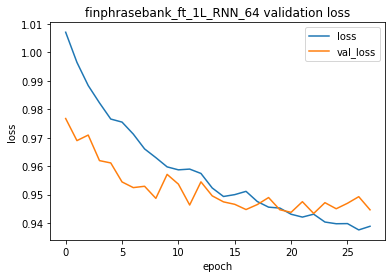

In [19]:
plt.plot(history_finphrasebank_ft_1L_RNN_64.history['loss'])
plt.plot(history_finphrasebank_ft_1L_RNN_64.history['val_loss'])
plt.title('finphrasebank_ft_1L_RNN_64 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

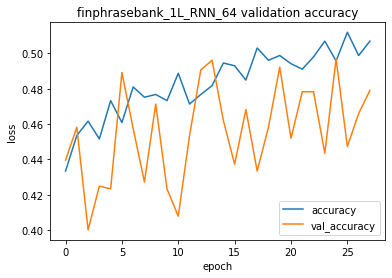

In [20]:
plt.plot(history_finphrasebank_ft_1L_RNN_64.history['categorical_accuracy'])
plt.plot(history_finphrasebank_ft_1L_RNN_64.history['val_categorical_accuracy'])
plt.title('finphrasebank_1L_RNN_64 validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [21]:
loss, acc = model2.evaluate(X_train_phrasebank_indixes, Y_oh_train_phrasebank)
print()
print("Accurary on train set = ", acc)

loss, acc = model2.evaluate(X_test_phrasebank_indixes, Y_oh_test_phrasebank)
print()
print("Accurary on test set = ", acc)

122/122 [==============================] - 1s 9ms/step - loss: 0.9635 - categorical_accuracy: 0.4982

Accurary on train set =  0.49819400906562805
31/31 [==============================] - 0s 9ms/step - loss: 0.9863 - categorical_accuracy: 0.4577

Accurary on test set =  0.4577319622039795


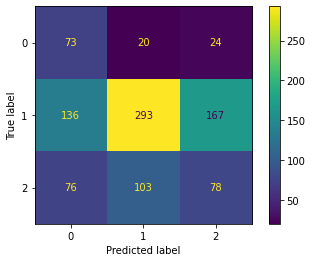

In [22]:
tmp = np.argmax(model2.predict(X_test_phrasebank_indixes),axis = 1)
tmp[tmp == 2] = -1

ConfusionMatrixDisplay(confusion_matrix(y_test_phrasebank, tmp, labels = [-1, 0,1])).plot()

# RNN model - pharse bank - Transfer As Initial

In [45]:
model = keras.models.load_model("./Model_callback/models/1L-RNN-64")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               46720     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 120,047,407
Trainable params: 47,107
Non-trainable params: 120,000,300
_________________________________________________________________


In [46]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/finphrasebank_1L-RNN-64",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/finphrasebank_1L-RNN-64"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam(learning_rate = 5e-4) 
model2.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer = opt)
history_finphrasebank_1L_RNN_64 = model2.fit(X_train_phrasebank_indixes, Y_oh_train_phrasebank, epochs = 50, batch_size = 64, 
                                             validation_split =  1/3, shuffle=True, sample_weight = y_train_phrasebank_weight,
                                             callbacks=my_callbacks)

Epoch 1/50
41/41 [==============================] - 9s 224ms/step - loss: 1.1123 - categorical_accuracy: 0.3974 - val_loss: 0.9661 - val_categorical_accuracy: 0.4543
Epoch 2/50
41/41 [==============================] - 8s 192ms/step - loss: 0.9435 - categorical_accuracy: 0.5155 - val_loss: 0.9172 - val_categorical_accuracy: 0.4946
Epoch 3/50
41/41 [==============================] - 8s 192ms/step - loss: 0.8460 - categorical_accuracy: 0.6029 - val_loss: 0.8407 - val_categorical_accuracy: 0.5333
Epoch 4/50
41/41 [==============================] - 9s 214ms/step - loss: 0.8042 - categorical_accuracy: 0.6022 - val_loss: 0.8324 - val_categorical_accuracy: 0.5782
Epoch 5/50
41/41 [==============================] - 8s 193ms/step - loss: 0.7353 - categorical_accuracy: 0.6718 - val_loss: 0.8237 - val_categorical_accuracy: 0.6331
Epoch 6/50
41/41 [==============================] - 9s 216ms/step - loss: 0.7085 - categorical_accuracy: 0.7020 - val_loss: 0.7904 - val_categorical_accuracy: 0.6424
Epoc

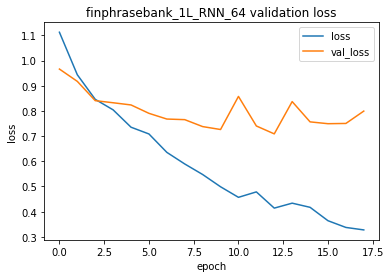

In [47]:
plt.plot(history_finphrasebank_1L_RNN_64.history['loss'])
plt.plot(history_finphrasebank_1L_RNN_64.history['val_loss'])
plt.title('finphrasebank_1L_RNN_64 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

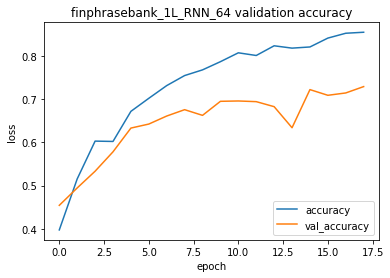

In [48]:
plt.plot(history_finphrasebank_1L_RNN_64.history['categorical_accuracy'])
plt.plot(history_finphrasebank_1L_RNN_64.history['val_categorical_accuracy'])
plt.title('finphrasebank_1L_RNN_64 validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [49]:
loss, acc = model2.evaluate(X_train_phrasebank_indixes, Y_oh_train_phrasebank)
print()
print("Accurary on train set = ", acc)

loss, acc = model2.evaluate(X_test_phrasebank_indixes, Y_oh_test_phrasebank)
print()
print("Accurary on test set = ", acc)

122/122 [==============================] - 1s 9ms/step - loss: 0.4540 - categorical_accuracy: 0.8284

Accurary on train set =  0.8284313678741455
31/31 [==============================] - 0s 9ms/step - loss: 0.6679 - categorical_accuracy: 0.7443

Accurary on test set =  0.7443298697471619


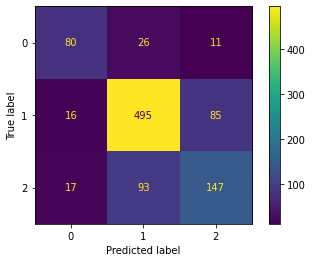

In [50]:
tmp = np.argmax(model2.predict(X_test_phrasebank_indixes),axis = 1)
tmp[tmp == 2] = -1

ConfusionMatrixDisplay(confusion_matrix(y_test_phrasebank, tmp, labels = [-1, 0,1])).plot()

# LSTM model - pharse bank - Fine Tuning Only

In [51]:
model = keras.models.load_model("./Model_callback/models/1L-LSTM128")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 120,440,367
Trainable params: 771
Non-trainable params: 120,439,596
_________________________________________________________________


In [52]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/finphrasebank_ft_1L-LSTM-128",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/finphrasebank_ft_1L-LSTM-128"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam() 
model2.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer = opt)
history_finphrasebank_ft_1L_LSTM_128 = model2.fit(X_train_phrasebank_indixes, Y_oh_train_phrasebank, epochs = 50, batch_size = 64, 
                                             validation_split =  1/3, shuffle=True, sample_weight = y_train_phrasebank_weight,
                                             callbacks=my_callbacks)

Epoch 1/50
41/41 [==============================] - 16s 383ms/step - loss: 1.0414 - categorical_accuracy: 0.3731 - val_loss: 0.9860 - val_categorical_accuracy: 0.4342
Epoch 2/50
41/41 [==============================] - 14s 346ms/step - loss: 0.9844 - categorical_accuracy: 0.4311 - val_loss: 0.9563 - val_categorical_accuracy: 0.4396
Epoch 3/50
41/41 [==============================] - 15s 373ms/step - loss: 0.9609 - categorical_accuracy: 0.4609 - val_loss: 0.9389 - val_categorical_accuracy: 0.4528
Epoch 4/50
41/41 [==============================] - 13s 322ms/step - loss: 0.9423 - categorical_accuracy: 0.4803 - val_loss: 0.9245 - val_categorical_accuracy: 0.4822
Epoch 5/50
41/41 [==============================] - 15s 357ms/step - loss: 0.9275 - categorical_accuracy: 0.4896 - val_loss: 0.9134 - val_categorical_accuracy: 0.5000
Epoch 6/50
41/41 [==============================] - 14s 349ms/step - loss: 0.9150 - categorical_accuracy: 0.5178 - val_loss: 0.9048 - val_categorical_accuracy: 0.504

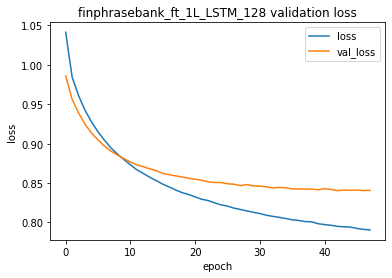

In [53]:
plt.plot(history_finphrasebank_ft_1L_LSTM_128.history['loss'])
plt.plot(history_finphrasebank_ft_1L_LSTM_128.history['val_loss'])
plt.title('finphrasebank_ft_1L_LSTM_128 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

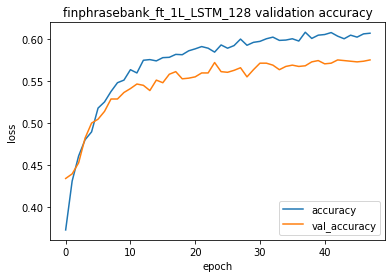

In [54]:
plt.plot(history_finphrasebank_ft_1L_LSTM_128.history['categorical_accuracy'])
plt.plot(history_finphrasebank_ft_1L_LSTM_128.history['val_categorical_accuracy'])
plt.title('finphrasebank_ft_1L_LSTM_128 validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [55]:
loss, acc = model2.evaluate(X_train_phrasebank_indixes, Y_oh_train_phrasebank)
print()
print("Accurary on train set = ", acc)

loss, acc = model2.evaluate(X_test_phrasebank_indixes, Y_oh_test_phrasebank)
print()
print("Accurary on test set = ", acc)

122/122 [==============================] - 1s 4ms/step - loss: 0.8350 - categorical_accuracy: 0.5952

Accurary on train set =  0.5952012538909912
31/31 [==============================] - 0s 4ms/step - loss: 0.8826 - categorical_accuracy: 0.5814

Accurary on test set =  0.5814433097839355


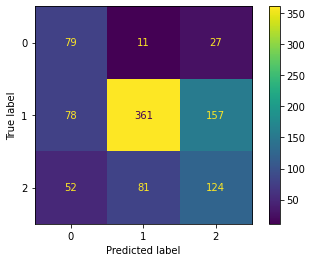

In [56]:
tmp = np.argmax(model2.predict(X_test_phrasebank_indixes),axis = 1)
tmp[tmp == 2] = -1

ConfusionMatrixDisplay(confusion_matrix(y_test_phrasebank, tmp, labels = [-1, 0,1])).plot()

 # LSTM model - pharse bank - Transfer As Initial

In [75]:
model = keras.models.load_model("./Model_callback/models/1L-LSTM128")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 771       
Total params: 120,440,367
Trainable params: 440,067
Non-trainable params: 120,000,300
_________________________________________________________________


In [76]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/finphrasebank_1L-LSTM-128",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/finphrasebank_1L-LSTM-128"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam(learning_rate = 5e-4) 
model2.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer = opt)
history_finphrasebank_1L_LSTM_128 = model2.fit(X_train_phrasebank_indixes, Y_oh_train_phrasebank, epochs = 50, batch_size = 64, 
                                             validation_split =  1/3, shuffle=True, sample_weight = y_train_phrasebank_weight,
                                             callbacks=my_callbacks)

Epoch 1/50
41/41 [==============================] - 16s 382ms/step - loss: 0.9936 - categorical_accuracy: 0.4826 - val_loss: 0.8502 - val_categorical_accuracy: 0.5751
Epoch 2/50
41/41 [==============================] - 13s 321ms/step - loss: 0.7509 - categorical_accuracy: 0.6529 - val_loss: 0.7378 - val_categorical_accuracy: 0.6463
Epoch 3/50
41/41 [==============================] - 16s 394ms/step - loss: 0.5708 - categorical_accuracy: 0.7295 - val_loss: 0.6806 - val_categorical_accuracy: 0.6548
Epoch 4/50
41/41 [==============================] - 13s 319ms/step - loss: 0.4423 - categorical_accuracy: 0.7875 - val_loss: 0.6677 - val_categorical_accuracy: 0.6927
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.3331 - categorical_accuracy: 0.8402 - val_loss: 0.7059 - val_categorical_accuracy: 0.6827
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.3022 - categorical_accuracy: 0.8611 - val_loss: 0.7596 - val_categorical_accuracy: 0.7376
Ep

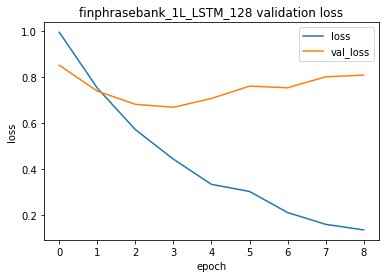

In [77]:
plt.plot(history_finphrasebank_1L_LSTM_128.history['loss'])
plt.plot(history_finphrasebank_1L_LSTM_128.history['val_loss'])
plt.title('finphrasebank_1L_LSTM_128 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

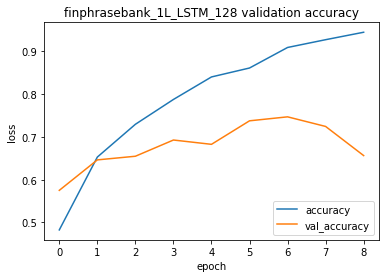

In [78]:
plt.plot(history_finphrasebank_1L_LSTM_128.history['categorical_accuracy'])
plt.plot(history_finphrasebank_1L_LSTM_128.history['val_categorical_accuracy'])
plt.title('finphrasebank_1L_LSTM_128 validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [79]:
loss, acc = model2.evaluate(X_train_phrasebank_indixes, Y_oh_train_phrasebank)
print()
print("Accurary on train set = ", acc)

loss, acc = model2.evaluate(X_test_phrasebank_indixes, Y_oh_test_phrasebank)
print()
print("Accurary on test set = ", acc)

122/122 [==============================] - 1s 4ms/step - loss: 0.5556 - categorical_accuracy: 0.7910

Accurary on train set =  0.7910216450691223
31/31 [==============================] - 0s 4ms/step - loss: 1.0024 - categorical_accuracy: 0.6454

Accurary on test set =  0.6453608274459839


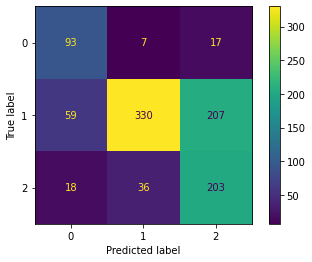

In [80]:
tmp = np.argmax(model2.predict(X_test_phrasebank_indixes),axis = 1)
tmp[tmp == 2] = -1

ConfusionMatrixDisplay(confusion_matrix(y_test_phrasebank, tmp, labels = [-1, 0,1])).plot()

# 2L-LSTM model - pharse bank - Fine Tuning Only

In [85]:
model = keras.models.load_model("./Model_callback/models/2L-LSTM128_128")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.layers[4].trainable = False
model2.layers[5].trainable = False
model2.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           439296    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 256)           1024      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

In [86]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/finphrasebank_ft_2L-LSTM128_128",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/finphrasebank_ft_2L-LSTM128_128"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam(learning_rate = 0.002) 
model2.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer = opt)
history_finphrasebank_ft_2L_LSTM128_128 = model2.fit(X_train_phrasebank_indixes, Y_oh_train_phrasebank, epochs = 50, batch_size = 64, 
                                             validation_split =  1/3, shuffle=True, sample_weight = y_train_phrasebank_weight,
                                             callbacks=my_callbacks)

Epoch 1/50
41/41 [==============================] - 27s 667ms/step - loss: 1.0365 - categorical_accuracy: 0.3851 - val_loss: 0.9356 - val_categorical_accuracy: 0.4296
Epoch 2/50
41/41 [==============================] - 28s 694ms/step - loss: 0.9708 - categorical_accuracy: 0.4570 - val_loss: 0.9071 - val_categorical_accuracy: 0.4892
Epoch 3/50
41/41 [==============================] - 23s 573ms/step - loss: 0.9477 - categorical_accuracy: 0.4779 - val_loss: 0.8923 - val_categorical_accuracy: 0.5101
Epoch 4/50
41/41 [==============================] - 28s 678ms/step - loss: 0.9311 - categorical_accuracy: 0.4896 - val_loss: 0.8839 - val_categorical_accuracy: 0.5139
Epoch 5/50
41/41 [==============================] - 23s 570ms/step - loss: 0.9195 - categorical_accuracy: 0.5008 - val_loss: 0.8793 - val_categorical_accuracy: 0.5209
Epoch 6/50
41/41 [==============================] - 27s 665ms/step - loss: 0.9147 - categorical_accuracy: 0.5209 - val_loss: 0.8750 - val_categorical_accuracy: 0.516

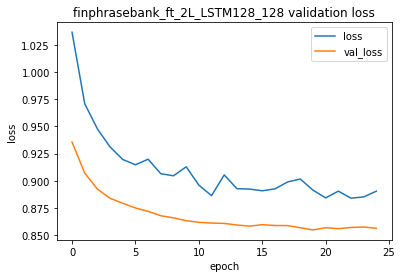

In [87]:
plt.plot(history_finphrasebank_ft_2L_LSTM128_128.history['loss'])
plt.plot(history_finphrasebank_ft_2L_LSTM128_128.history['val_loss'])
plt.title('finphrasebank_ft_2L_LSTM128_128 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')

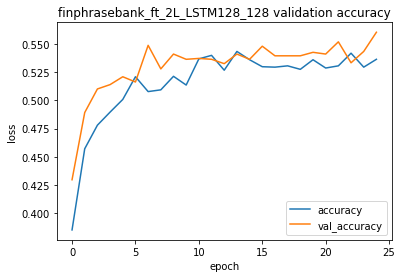

In [88]:
plt.plot(history_finphrasebank_ft_2L_LSTM128_128.history['categorical_accuracy'])
plt.plot(history_finphrasebank_ft_2L_LSTM128_128.history['val_categorical_accuracy'])
plt.title('finphrasebank_ft_2L_LSTM128_128 validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [89]:
loss, acc = model2.evaluate(X_train_phrasebank_indixes, Y_oh_train_phrasebank)
print()
print("Accurary on train set = ", acc)

loss, acc = model2.evaluate(X_test_phrasebank_indixes, Y_oh_test_phrasebank)
print()
print("Accurary on test set = ", acc)

122/122 [==============================] - 1s 7ms/step - loss: 0.8799 - categorical_accuracy: 0.5764

Accurary on train set =  0.5763673782348633
31/31 [==============================] - 0s 6ms/step - loss: 0.8928 - categorical_accuracy: 0.5515

Accurary on test set =  0.5515463948249817


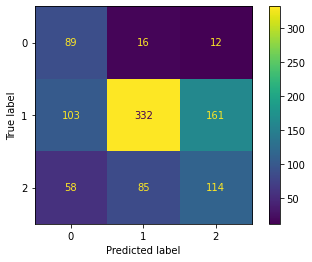

In [90]:
tmp = np.argmax(model2.predict(X_test_phrasebank_indixes),axis = 1)
tmp[tmp == 2] = -1

ConfusionMatrixDisplay(confusion_matrix(y_test_phrasebank, tmp, labels = [-1, 0,1])).plot()

# 2L-LSTM model - pharse bank - Transfer as Initial

In [95]:
model = keras.models.load_model("./Model_callback/models/2L-LSTM128_128")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           439296    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 256)           1024      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

In [96]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/finphrasebank_2L-LSTM128_128",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/finphrasebank_2L-LSTM128_128"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam(learning_rate = 2e-4) 
model2.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer = opt)
history_finphrasebank_2L_LSTM128_128 = model2.fit(X_train_phrasebank_indixes, Y_oh_train_phrasebank, epochs = 50, batch_size = 64, 
                                             validation_split =  1/3, shuffle=True, sample_weight = y_train_phrasebank_weight,
                                             callbacks=my_callbacks)

Epoch 1/50
41/41 [==============================] - 26s 627ms/step - loss: 1.0328 - categorical_accuracy: 0.4067 - val_loss: 0.9510 - val_categorical_accuracy: 0.4141
Epoch 2/50
41/41 [==============================] - 28s 688ms/step - loss: 0.8856 - categorical_accuracy: 0.5368 - val_loss: 0.8395 - val_categorical_accuracy: 0.5325
Epoch 3/50
41/41 [==============================] - 24s 580ms/step - loss: 0.7755 - categorical_accuracy: 0.6080 - val_loss: 0.7784 - val_categorical_accuracy: 0.6269
Epoch 4/50
41/41 [==============================] - 30s 741ms/step - loss: 0.6944 - categorical_accuracy: 0.6409 - val_loss: 0.7218 - val_categorical_accuracy: 0.6293
Epoch 5/50
41/41 [==============================] - 1s 19ms/step - loss: 0.6183 - categorical_accuracy: 0.6761 - val_loss: 0.7385 - val_categorical_accuracy: 0.6896
Epoch 6/50
41/41 [==============================] - 1s 18ms/step - loss: 0.5662 - categorical_accuracy: 0.7214 - val_loss: 0.7230 - val_categorical_accuracy: 0.7152
Ep

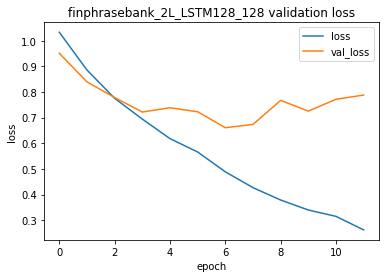

In [97]:
plt.plot(history_finphrasebank_2L_LSTM128_128.history['loss'])
plt.plot(history_finphrasebank_2L_LSTM128_128.history['val_loss'])
plt.title('finphrasebank_2L_LSTM128_128 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

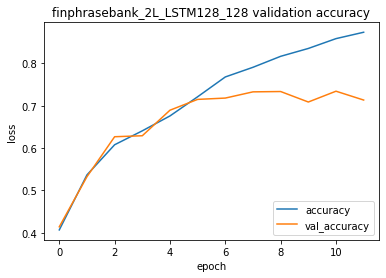

In [98]:
plt.plot(history_finphrasebank_2L_LSTM128_128.history['categorical_accuracy'])
plt.plot(history_finphrasebank_2L_LSTM128_128.history['val_categorical_accuracy'])
plt.title('finphrasebank_2L_LSTM128_128 validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [99]:
loss, acc = model2.evaluate(X_train_phrasebank_indixes, Y_oh_train_phrasebank)
print()
print("Accurary on train set = ", acc)

loss, acc = model2.evaluate(X_test_phrasebank_indixes, Y_oh_test_phrasebank)
print()
print("Accurary on test set = ", acc)

122/122 [==============================] - 1s 7ms/step - loss: 0.4312 - categorical_accuracy: 0.8421

Accurary on train set =  0.8421052694320679
31/31 [==============================] - 0s 6ms/step - loss: 0.8167 - categorical_accuracy: 0.6918

Accurary on test set =  0.691752552986145


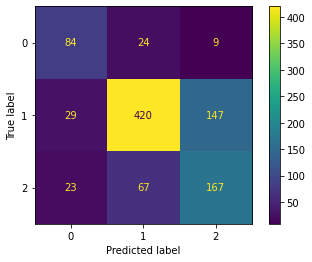

In [100]:
tmp = np.argmax(model2.predict(X_test_phrasebank_indixes),axis = 1)
tmp[tmp == 2] = -1

ConfusionMatrixDisplay(confusion_matrix(y_test_phrasebank, tmp, labels = [-1, 0,1])).plot()

# 3L-LSTM model - pharse bank - Fine Tuning Only

In [105]:
model = keras.models.load_model("./Model_callback/models/3L-LSTM128_128_64")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.layers[4].trainable = False
model2.layers[5].trainable = False
model2.layers[7].trainable = False
model2.layers[8].trainable = False
model2.summary()

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           439296    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 256)           1024      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)         

In [106]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/finphrasebank_ft_3L-LSTM128_128_64",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/finphrasebank_ft_3L-LSTM128_128_64"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam(learning_rate = 0.005) 
model2.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer = opt)
history_finphrasebank_ft_3L_LSTM128_128_64 = model2.fit(X_train_phrasebank_indixes, Y_oh_train_phrasebank, epochs = 50, batch_size = 64, 
                                             validation_split =  1/3, shuffle=True, sample_weight = y_train_phrasebank_weight,
                                             callbacks=my_callbacks)

Epoch 1/50
41/41 [==============================] - 36s 869ms/step - loss: 1.0538 - categorical_accuracy: 0.3924 - val_loss: 0.9401 - val_categorical_accuracy: 0.3862
Epoch 2/50
41/41 [==============================] - 35s 855ms/step - loss: 0.9992 - categorical_accuracy: 0.4009 - val_loss: 0.9196 - val_categorical_accuracy: 0.5217
Epoch 3/50
41/41 [==============================] - 41s 998ms/step - loss: 0.9733 - categorical_accuracy: 0.4396 - val_loss: 0.9096 - val_categorical_accuracy: 0.5124
Epoch 4/50
41/41 [==============================] - 34s 819ms/step - loss: 0.9770 - categorical_accuracy: 0.4319 - val_loss: 0.9015 - val_categorical_accuracy: 0.5046
Epoch 5/50
41/41 [==============================] - 34s 825ms/step - loss: 0.9584 - categorical_accuracy: 0.4454 - val_loss: 0.8984 - val_categorical_accuracy: 0.4458
Epoch 6/50
41/41 [==============================] - 42s 1s/step - loss: 0.9509 - categorical_accuracy: 0.4524 - val_loss: 0.8910 - val_categorical_accuracy: 0.5155
E

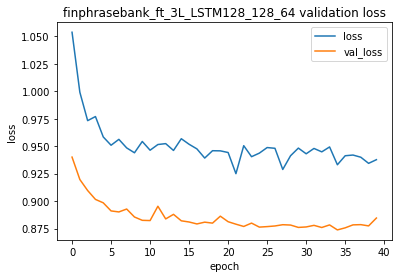

In [111]:
plt.plot(history_finphrasebank_ft_3L_LSTM128_128_64.history['loss'])
plt.plot(history_finphrasebank_ft_3L_LSTM128_128_64.history['val_loss'])
plt.title('finphrasebank_ft_3L_LSTM128_128_64 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

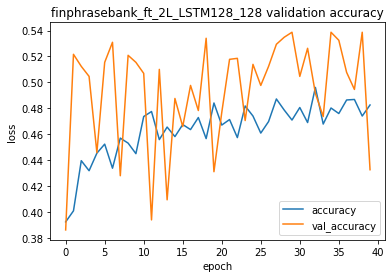

In [112]:
plt.plot(history_finphrasebank_ft_3L_LSTM128_128_64.history['categorical_accuracy'])
plt.plot(history_finphrasebank_ft_3L_LSTM128_128_64.history['val_categorical_accuracy'])
plt.title('finphrasebank_ft_2L_LSTM128_128 validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [113]:
loss, acc = model2.evaluate(X_train_phrasebank_indixes, Y_oh_train_phrasebank)
print()
print("Accurary on train set = ", acc)

loss, acc = model2.evaluate(X_test_phrasebank_indixes, Y_oh_test_phrasebank)
print()
print("Accurary on test set = ", acc)

122/122 [==============================] - 1s 9ms/step - loss: 0.9553 - categorical_accuracy: 0.4404

Accurary on train set =  0.44040247797966003
31/31 [==============================] - 0s 9ms/step - loss: 0.9633 - categorical_accuracy: 0.4144

Accurary on test set =  0.41443300247192383


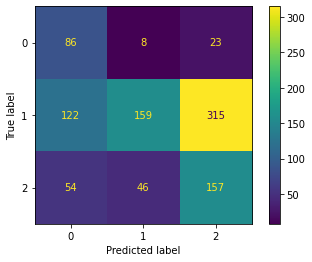

In [114]:
tmp = np.argmax(model2.predict(X_test_phrasebank_indixes),axis = 1)
tmp[tmp == 2] = -1

ConfusionMatrixDisplay(confusion_matrix(y_test_phrasebank, tmp, labels = [-1, 0,1])).plot()

# 3L-LSTM model - pharse bank - Transfer as initial

In [122]:
model = keras.models.load_model("./Model_callback/models/3L-LSTM128_128_64")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.summary()

Model: "functional_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           439296    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 256)           1024      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)         

In [123]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/finphrasebank_3L-LSTM128_128_64",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/finphrasebank_3L-LSTM128_128_64"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam(learning_rate = 1e-4) 
model2.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer = opt)
history_finphrasebank_3L_LSTM128_128_64 = model2.fit(X_train_phrasebank_indixes, Y_oh_train_phrasebank, epochs = 50, batch_size = 64, 
                                             validation_split =  1/3, shuffle=True, sample_weight = y_train_phrasebank_weight,
                                             callbacks=my_callbacks)

Epoch 1/50
41/41 [==============================] - 36s 884ms/step - loss: 1.2265 - categorical_accuracy: 0.2968 - val_loss: 1.0791 - val_categorical_accuracy: 0.3785
Epoch 2/50
41/41 [==============================] - 40s 983ms/step - loss: 1.0791 - categorical_accuracy: 0.4033 - val_loss: 1.0560 - val_categorical_accuracy: 0.3870
Epoch 3/50
41/41 [==============================] - 34s 838ms/step - loss: 1.0335 - categorical_accuracy: 0.4249 - val_loss: 1.0125 - val_categorical_accuracy: 0.4474
Epoch 4/50
41/41 [==============================] - 34s 831ms/step - loss: 0.9427 - categorical_accuracy: 0.4872 - val_loss: 0.9428 - val_categorical_accuracy: 0.4954
Epoch 5/50
41/41 [==============================] - 46s 1s/step - loss: 0.9180 - categorical_accuracy: 0.5050 - val_loss: 0.8980 - val_categorical_accuracy: 0.5410
Epoch 6/50
41/41 [==============================] - 64s 2s/step - loss: 0.8686 - categorical_accuracy: 0.5306 - val_loss: 0.8464 - val_categorical_accuracy: 0.5596
Epoc

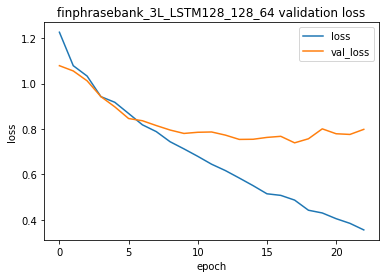

In [124]:
plt.plot(history_finphrasebank_3L_LSTM128_128_64.history['loss'])
plt.plot(history_finphrasebank_3L_LSTM128_128_64.history['val_loss'])
plt.title('finphrasebank_3L_LSTM128_128_64 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

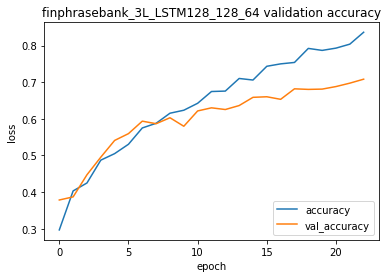

In [125]:
plt.plot(history_finphrasebank_3L_LSTM128_128_64.history['categorical_accuracy'])
plt.plot(history_finphrasebank_3L_LSTM128_128_64.history['val_categorical_accuracy'])
plt.title('finphrasebank_3L_LSTM128_128_64 validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [126]:
loss, acc = model2.evaluate(X_train_phrasebank_indixes, Y_oh_train_phrasebank)
print()
print("Accurary on train set = ", acc)

loss, acc = model2.evaluate(X_test_phrasebank_indixes, Y_oh_test_phrasebank)
print()
print("Accurary on test set = ", acc)

122/122 [==============================] - 1s 9ms/step - loss: 0.4485 - categorical_accuracy: 0.8308

Accurary on train set =  0.8307533264160156
31/31 [==============================] - 0s 9ms/step - loss: 0.7480 - categorical_accuracy: 0.7031

Accurary on test set =  0.7030927538871765


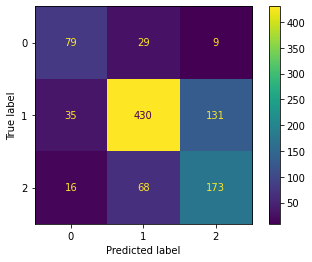

In [127]:
tmp = np.argmax(model2.predict(X_test_phrasebank_indixes),axis = 1)
tmp[tmp == 2] = -1

ConfusionMatrixDisplay(confusion_matrix(y_test_phrasebank, tmp, labels = [-1, 0,1])).plot()